In [1]:
from prophet import Prophet
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np
sns.set()

In [2]:
from mango import scheduler, Tuner

# MODEL

### Upload data

In [3]:
datetime_format = "%Y-%m-%d" 
df = pd.read_csv('datasets/preprocessed_full_sales_data.csv',  index_col=0, parse_dates=['Date'], date_format=datetime_format)
df_sorted = df.sort_values('Date')

In [4]:
# period_for_prediction = 300
# interval = 1115 * period_for_prediction    ## 1115 stores * period_for_prediction

### Define the holidays

In [5]:
# Define the holiday column by checking the conditions and assigning names
holidays = df_sorted[
    (df_sorted.Christmas == 1) | 
    (df_sorted.Easter_holiday == 1) | 
    (df_sorted.Public_holiday == 1)
].copy()

# Assign holiday names based on the conditions
holidays['holiday'] = holidays.apply(
    lambda row: 'Christmas' if row.Christmas == 1 else 
                'Easter_holiday' if row.Easter_holiday == 1 else 
                'Public_holiday' if row.Public_holiday == 1 else None, axis=1
)

# Select only the required columns for Prophet
HOLIDAYS = holidays[['holiday', 'Date']].rename(columns={'Date': 'ds'})

# Set lower window (20 for Christmas, 2 for other holidays)
HOLIDAYS ['lower_window'] = holidays.apply(lambda x: -20 if x['holiday'] == 'Christmas' else -2, axis=1)
HOLIDAYS ['upper_window'] = 0

### Prophet model

In [11]:
# Parameters for forward-chaining
initial_train_size = int(len(df_sorted) * 0.6)  # Start with 60% of data as initial training
expanding_steps = int(len(df_sorted) * 0.1)  # Expand by 10% each iteration

In [42]:
def store_sales_predictor(Store_ID: int, 
                         df: pd.DataFrame, 
                         holidays: pd.DataFrame = None, 
                         initial_train_size_multiplayer: float = 0.6, 
                         test_size_multiplayer: float = 0.1,
                         prediction_period: int = 100,
                         **model_params: None):
    """
    This function forecasts sales for a specified store using a forward-chaining approach. 
    It splits the dataset into progressively larger training sets and test sets, ensuring 
    that each test set follows the training set chronologically. The function evaluates 
    the model's performance at each test step and generates a final forecast.

    Parameters:
    - Store_ID (int): Identifier for the store to filter and analyze sales data.
    - df (pd.DataFrame): Input data containing 'Store', 'Date', and 'Sales' columns.
    - holidays (pd.DataFrame, optional): DataFrame of holiday dates for the Prophet model 
      to incorporate. Defaults to None.
    - initial_train_size_multiplayer (float): Proportion of the data to use as the initial 
      training set. Must be between 0 and 1. Default is 0.6.
    - test_size_multiplayer (float): Proportion of the data to use as test steps in the 
      forward-chaining process. Must be between 0 and 1. Default is 0.1.
    - prediction_period (int): Number of future periods to forecast in the final iteration.
      Default is 100.
    - **model_params: Additional parameters to customize the Prophet model.

    Returns:
    - predictions_table (pd.DataFrame): Aggregated DataFrame of predictions, residuals, 
      and percentage errors for all test sets.
    - model_metrics (pd.DataFrame): Performance metrics (MSE, MAE, RMSE, and relative error) 
      for each forward-chaining test step.
    - last_forecast (pd.DataFrame): Forecasted results for the specified `prediction_period`.
    - last_train_set (pd.DataFrame): Training set used in the final iteration.
    - last_test_set (pd.DataFrame): Test set used in the final iteration.
    """

   # Variables for final report
    model_metrics = pd.DataFrame()
    predictions_table = pd.DataFrame()
    step = 1
    last_forecast = None
    last_train_set = None
    last_test_set = None
    
    # Filter data for the selected Store_ID
    store_df = df[df["Store"] == Store_ID]
    store_df = store_df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    # store_df = store_df[store_df['y'] < store_df['y'].quantile(0.99)]  # clear outliers (optionally)
    store_df = store_df.sort_values('ds')
    
    # Validate multipliers
    if not (0 < initial_train_size_multiplayer < 1) or not (0 < test_size_multiplayer < 1):
        raise ValueError("Multipliers must be between 0 and 1.")
    initial_train_size = int(len(store_df) * initial_train_size_multiplayer) # 60% by default (`500)
    expanding_steps = int(len(store_df) * test_size_multiplayer)  # 10% by default (`70)

    for start in range(0, len(store_df) - initial_train_size, expanding_steps):
        # Train/test data chained splitting
        train_end = initial_train_size + start
        test_end = min(train_end + expanding_steps, len(store_df))

        train = store_df.iloc[:train_end]
        test = store_df.iloc[train_end:test_end]

        if not test.empty and len(test) > 30:
            # Model
            last_train = train
            last_test = test
            model = Prophet(holidays=holidays, **model_params)
            model.fit(train)
            future = model.make_future_dataframe(periods=len(test), freq='D')
            forecast = model.predict(future)

            # Prediction-Target table
            predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test, on='ds', how='inner')
            predictions["Residuals"] = predictions["y"] - predictions["yhat"]
            predictions["Difference%"] = np.abs(predictions["Residuals"] / predictions["y"] * 100)
            predictions["Test_Number"] = step

            # Check and handle NaNs
            if predictions[['y', 'yhat']].isna().any().any():
                print(f"Warning: {predictions[['y', 'yhat']].isna().sum()} NaNs found in predictions during step {step}.")
                print(predictions[predictions.isna().any(axis=1)])
                predictions = predictions.dropna(subset=['y', 'yhat'])  # Drop rows with NaNs
            
            # Skip if no valid predictions remain
            if predictions.empty:
                print(f"No valid predictions for step {step}, skipping...")
                continue

            mse = mean_squared_error(predictions['y'], predictions['yhat'])
            mae = mean_absolute_error(predictions['y'], predictions['yhat'])
            rmse = np.sqrt(mse)
            current_metrics = pd.DataFrame([{'test_step': step,
                                             'data_start': predictions.iloc[0, 0],
                                             'data_end': predictions.iloc[-1, 0],
                                             'test_start': train_end,
                                             'test_end': test_end,
                                             'test batch size': test_end-train_end,
                                             'MSE': mse,
                                             'MAE': mae,
                                             'RMSE': rmse,
                                             'Store_Mean_Sales': store_df['y'].mean(),
                                             'Relative_Error%': rmse/store_df['y'].mean()*100
                                             }])

            # Add data for reports
            model_metrics = pd.concat([model_metrics, current_metrics], ignore_index=True)
            predictions_table = pd.concat([predictions_table, predictions])
            step += 1
        else:
            future = model.make_future_dataframe(periods=prediction_period)
            last_forecast = model.predict(future)

            plt.figure(figsize=(14, 8))
            model.plot(last_forecast, xlabel='Date', ylabel='Sales')
            plt.plot()
            plt.title(f'Sales Forecast for Store #{Store_ID}')
            model.plot_components(forecast)

    
    return predictions_table, model_metrics, last_forecast, last_train_set, last_test_set

In [13]:
def plot_metrics(all_metrics: object):
    fig, ax1 = plt.subplots(figsize=(11, 4))
    
    # First y-axis for MSE
    ax1.set_xlabel('test_step')
    ax1.set_ylabel('MSE', color='#155E95')
    ax1.plot(all_metrics['test_step'], all_metrics['MSE'], label='MSE', marker='o', color='#155E95')
    ax1.tick_params(axis='y', labelcolor='#155E95')
    ax1.set_xticks([1, 2, 3, 4])
    
    # Second y-axis for MAE and RMSE
    ax2 = ax1.twinx()
    ax2.set_ylabel('MAE and RMSE', color='orange')
    ax2.plot(all_metrics['test_step'], all_metrics['MAE'], label='MAE', marker='o', color='orange', linestyle='-')
    ax2.plot(all_metrics['test_step'], all_metrics['RMSE'], label='RMSE', marker='o', color='orange', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(400, 1600)
    
    # Adding legends for both y-axes
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    # Title and grid
    plt.title('Evaluating Error Metrics Across Forward-Chaining Test Steps')
    fig.tight_layout()
    plt.grid()
    plt.show()

## Prophet model implementation

In [14]:
STORE_ID = 40
PREDICTION_PERIOD = 200

19:51:25 - cmdstanpy - INFO - Chain [1] start processing
19:51:25 - cmdstanpy - INFO - Chain [1] done processing
19:51:25 - cmdstanpy - INFO - Chain [1] start processing
19:51:25 - cmdstanpy - INFO - Chain [1] done processing
19:51:26 - cmdstanpy - INFO - Chain [1] start processing
19:51:26 - cmdstanpy - INFO - Chain [1] done processing
19:51:27 - cmdstanpy - INFO - Chain [1] start processing
19:51:27 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x800 with 0 Axes>

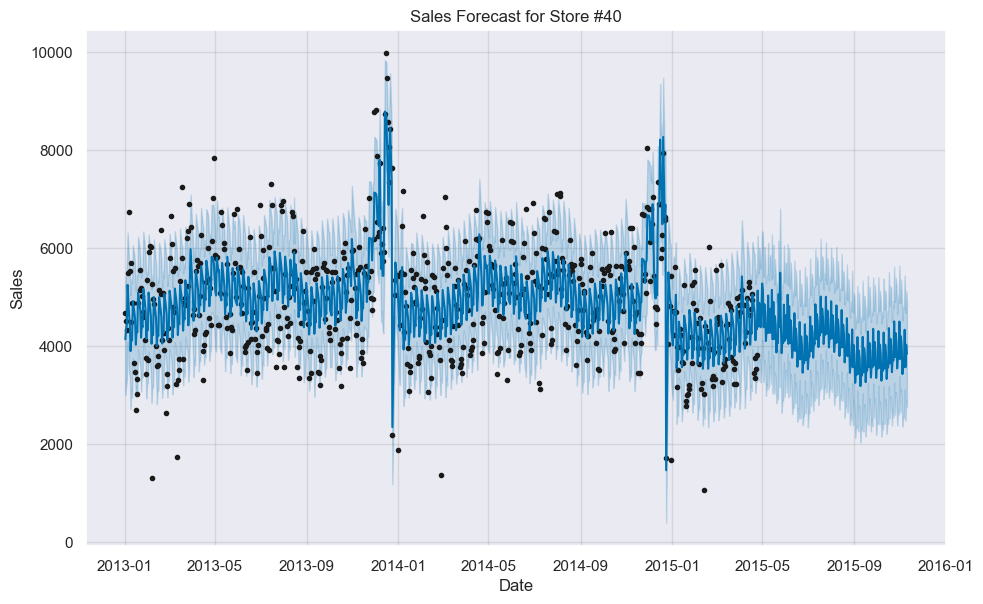

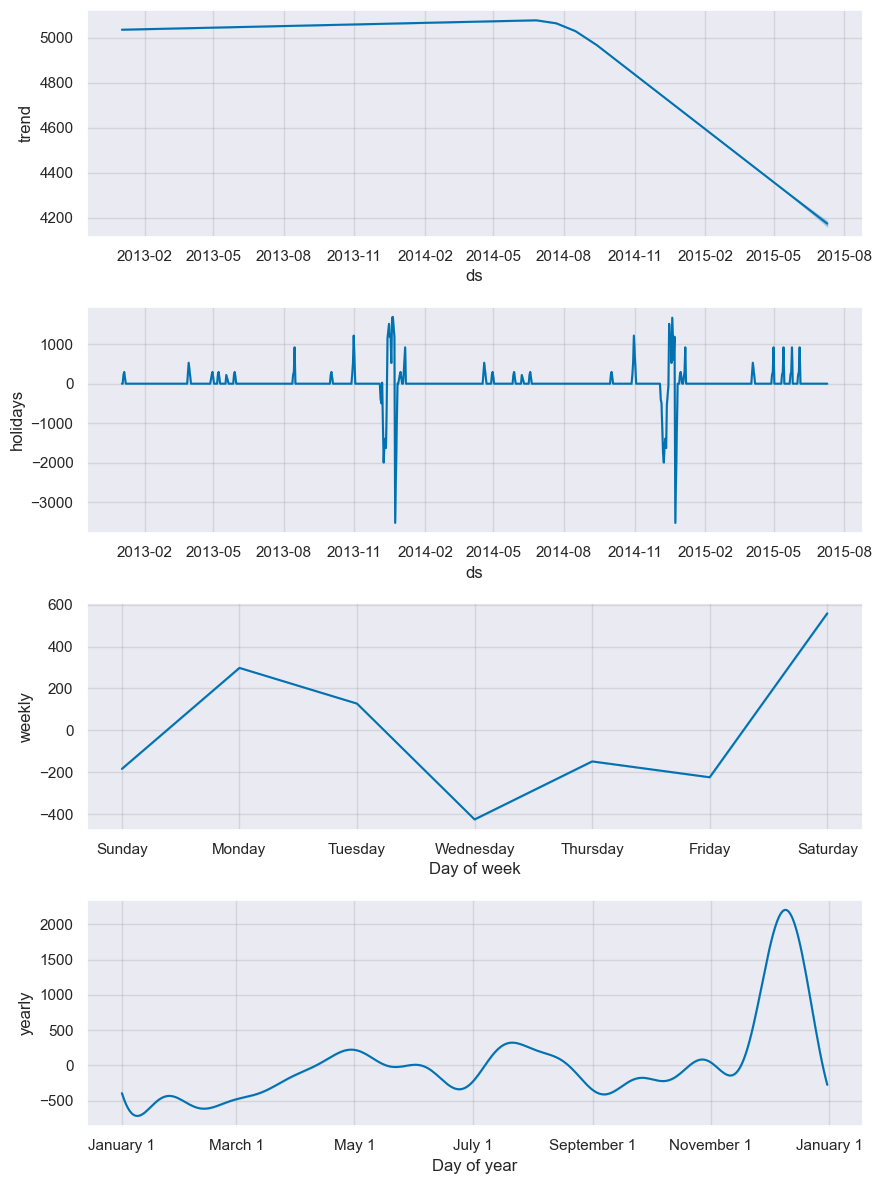

In [43]:
predictions, metrics, forecast, train, test = store_sales_predictor(Store_ID=STORE_ID, df=df_sorted, holidays=HOLIDAYS, prediction_period=PREDICTION_PERIOD)

## Stepwise Model Evaluation Metrics and Results

In [16]:
predictions.describe()

,ds,yhat,yhat_lower,yhat_upper,y,Residuals,Difference%
count,252,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,2015-01-11 11:02:51.428571392,4775.608710,3592.015524,5953.748971,4766.571429,-9.037282,15.770515
min,2014-07-21 00:00:00,1712.831795,543.295423,2864.386889,1052.000000,-3427.264634,0.110823
25%,2014-10-01 18:00:00,4163.971054,3063.594003,5295.181990,4052.000000,-548.191485,5.295115
50%,2015-01-02 12:00:00,4730.844979,3527.353296,5904.499567,4725.000000,11.953816,12.445300
75%,2015-04-07 06:00:00,5186.142521,3971.880540,6433.489567,5433.500000,632.347218,19.289153
max,2015-07-10 00:00:00,9754.122138,8541.233989,10937.673886,8032.000000,2457.873588,271.512812
std,NaN,889.057815,861.785029,921.661851,1061.225105,899.296074,22.994351


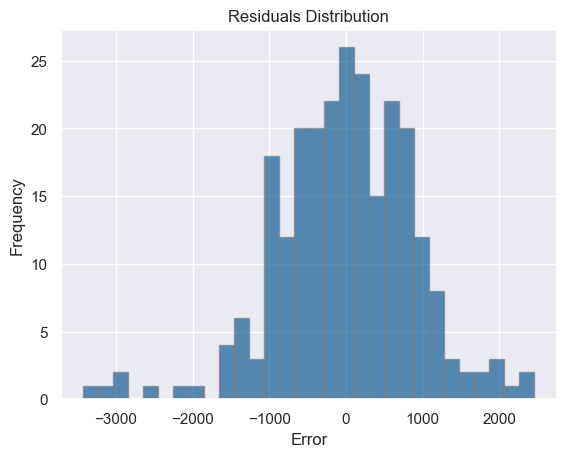

In [17]:
plt.hist(predictions['Residuals'], bins=30, color='#155E95', edgecolor='grey', alpha = 0.7)
plt.title('Residuals Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

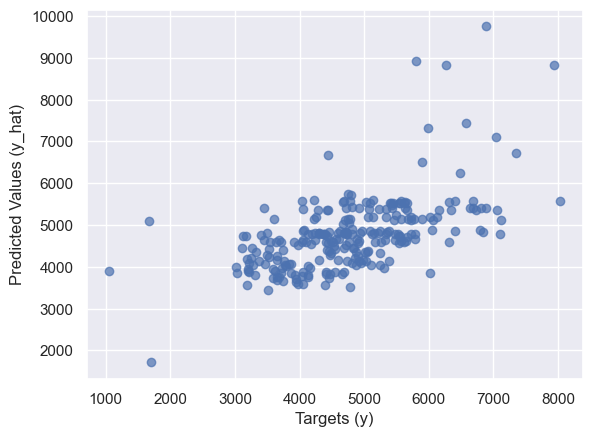

In [18]:
plt.scatter(predictions['y'], predictions['yhat'], alpha = 0.7)
plt.xlabel('Targets (y)')
plt.ylabel('Predicted Values (y_hat)')
plt.show()

In [19]:
metrics

,test_step,data_start,data_end,test_start,test_end,test batch size,MSE,MAE,RMSE,Store_Mean_Sales,Relative_Error%
0,1,2014-07-21,2014-10-04,465,542,77,6.560701e+05,639.945532,809.981568,4902.338918,16.522349
1,2,2014-10-20,2015-01-03,542,619,77,1.495681e+06,930.868694,1222.980319,4902.338918,24.946874
2,3,2015-01-22,2015-04-08,619,696,77,6.165497e+05,597.106791,785.206776,4902.338918,16.016983
3,4,2015-04-25,2015-07-10,696,773,77,4.644076e+05,564.025222,681.474560,4902.338918,13.901009


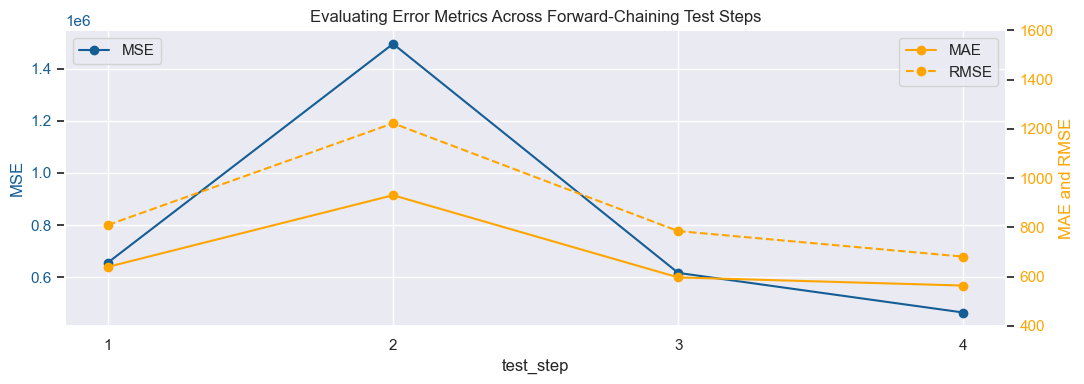

In [20]:
plot_metrics(metrics)

In [44]:
predictions

,ds,yhat,yhat_lower,yhat_upper,y,Residuals,Difference%,Test_Number
0,2014-07-21,5354.470379,4093.188473,6520.531624,6735,1380.529621,20.497841,1
1,2014-07-22,5125.522511,3863.396819,6315.206748,5467,341.477489,6.246159,1
2,2014-07-23,4583.108653,3255.868906,5793.007392,4035,-548.108653,13.583858,1
3,2014-07-24,4780.541393,3563.011279,6094.493359,4359,-421.541393,9.670599,1
4,2014-07-25,4780.465775,3486.186411,6092.664956,4127,-653.465775,15.833918,1
...,...,...,...,...,...,...,...,...
57,2015-07-06,4408.708126,3315.871514,5625.581297,3747,-661.708126,17.659678,4
58,2015-07-07,4275.035846,3126.054502,5395.080282,3496,-779.035846,22.283634,4
59,2015-07-08,3758.858788,2679.068958,4858.976849,3678,-80.858788,2.198444,4
60,2015-07-09,4072.561025,3043.761229,5291.884946,3873,-199.561025,5.152621,4


In [46]:
predictions

,ds,yhat,yhat_lower,yhat_upper,y,Residuals,Difference%,Test_Number
0,2014-07-21,5354.470379,4093.188473,6520.531624,6735,1380.529621,20.497841,1
1,2014-07-22,5125.522511,3863.396819,6315.206748,5467,341.477489,6.246159,1
2,2014-07-23,4583.108653,3255.868906,5793.007392,4035,-548.108653,13.583858,1
3,2014-07-24,4780.541393,3563.011279,6094.493359,4359,-421.541393,9.670599,1
4,2014-07-25,4780.465775,3486.186411,6092.664956,4127,-653.465775,15.833918,1
...,...,...,...,...,...,...,...,...
57,2015-07-06,4408.708126,3315.871514,5625.581297,3747,-661.708126,17.659678,4
58,2015-07-07,4275.035846,3126.054502,5395.080282,3496,-779.035846,22.283634,4
59,2015-07-08,3758.858788,2679.068958,4858.976849,3678,-80.858788,2.198444,4
60,2015-07-09,4072.561025,3043.761229,5291.884946,3873,-199.561025,5.152621,4


In [67]:
def train_test_data_plot(predictions: pd.DataFrame, forecast, store_id: int):
      # Calculate performance metrics
      mae = mean_absolute_error(predictions['y'], predictions['yhat'])
      mse = mean_squared_error(predictions['y'], predictions['yhat'])
      rmse = np.sqrt(mse)

      # Plot actual, predicted, and training data
      plt.figure(figsize=(15, 8))
      ax = plt.gca()   
      
      
      # plt.plot(sales_df['ds'], sales_df['y'], label='Training Data', color='blue', linestyle='--')
      ax.plot(predictions['ds'], predictions['y'], label='Actual Test Data', color='blue')
      ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', color='red', linestyle='-')
      ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.4, label='Prediction Uncertainty')
      plt.xlabel('Date')
      plt.ylabel('Sales')
      plt.title(f'Store {store_id}: Actual vs Predicted Sales')

      # Highlight training data
      ax.axvspan(forecast.iloc[0,0], predictions.iloc[0,0], color='#B0A695', alpha=0.2)
      ax.text(forecast.iloc[int(len(forecast)*0.2), 0], max(predictions['y']), 'Train data', color='grey', fontsize=10, ha='center', va='bottom', rotation=0)

      # Highlight test data
      for test_number in range(1, len(predictions['Test_Number'].unique())+1):
          df = predictions[predictions['Test_Number'] == test_number]
          ax.axvspan(df.iloc[0,0], df.iloc[-1,0], color='green', alpha=0.2)
          ax.text(df.iloc[int(len(df)*0.2), 0], int(max(df['y'])*1.2), f'Test data (batch #{test_number})', color='grey', fontsize=10, ha='center', va='bottom', rotation=90)
          
      # Highlight predictions
      ax.axvspan(predictions.iloc[-1,0], forecast.iloc[-1, 0], color='red', alpha=0.2)
      ax.text(predictions.iloc[-1,0]+pd.Timedelta(days=15), 5, f'Predicted data', color='grey', fontsize=10, ha='center', va='bottom', rotation=90)

    
      plt.legend()
      plt.grid()
      plt.show()

      print(f"MAE={mae}, MSE={mse}, RMSE={rmse}")

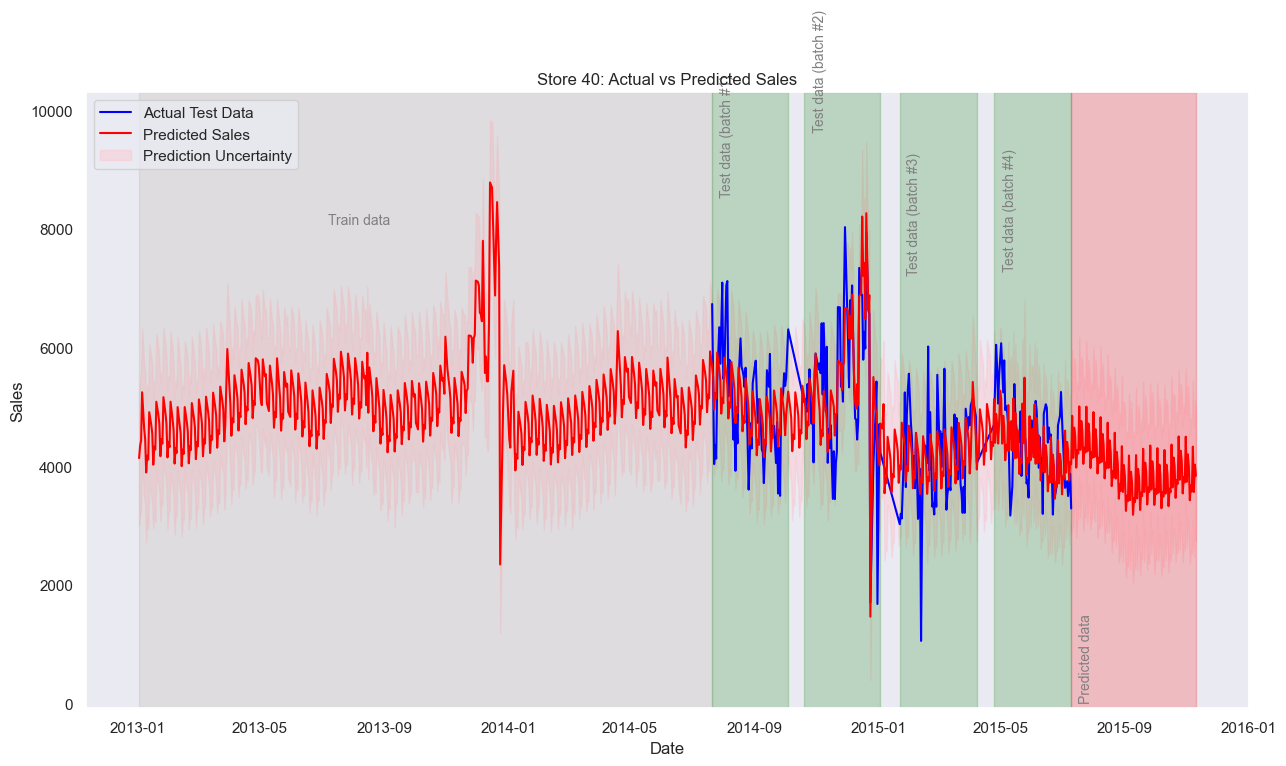

MAE=682.1333741336275, MSE=805605.8420416716, RMSE=897.5554813167104


In [68]:
train_test_data_plot(predictions, forecast, STORE_ID)

## Hyperparameter Tuning

In [23]:
# Define parameter space for hyperparameter tuning
param_space = dict(
        growth = ['linear', 'logistic', 'flat'],
        n_changepoints = range(0, 55, 5),
        changepoint_range = uniform(0.5, 0.5),
        yearly_seasonality = [True, False],
        weekly_seasonality = [True, False],
        daily_seasonality = [True, False],
        seasonality_mode = ['additive', 'multiplicative'],
        seasonality_prior_scale = uniform(5.0, 15.0),
        changepoint_prior_scale = uniform(0.0, 0.1),
        interval_width = uniform(0.2, 0.8),
        uncertainty_samples = [500, 1000, 1500, 2000]
    )
    

def objective_function(args_list): 
    global train, test, holidays
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            model = Prophet(holidays=holidays, **params)
            model.fit(train)
            future = model.make_future_dataframe(periods=len(test), freq='D')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(len(test))
            error = mape(test['y'], predictions_tuned['yhat'])   
            
            params_evaluated.append(params)
            results.append(error)
        except:
            params_evaluated.append(params)
            results.append(25.0)             # Giving high loss for exceptions regions of spaces
        
        print(params_evaluated, mse)
    return params_evaluated, results


conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50

tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

# best parameters = {'changepoint_prior_scale': 0.025591458575111727, 
#                   'changepoint_range': 0.657839604539936, 
#                   'daily_seasonality': True, 'growth': 'linear', 
#                   'interval_width': 0.38332468729422325, 
#                   'n_changepoints': 45, 
#                   'seasonality_mode': 'additive', 
#                   'seasonality_prior_scale': 13.512049816459474, 
#                   'uncertainty_samples': 2000, 
#                   'weekly_seasonality': True, 
#                   'yearly_seasonality': True}


# best_parameters = {'changepoint_prior_scale': 0.04582943151868612, 
#                   'changepoint_range': 0.7005423245722295, 
#                   'daily_seasonality': False, 
#                   'growth': 'flat', 
#                   'interval_width': 0.5243539565302783,
#                   'n_changepoints': 5, 
#                   'seasonality_mode': 'multiplicative', 
#                   'seasonality_prior_scale': 10.04484823291632, 
#                   'uncertainty_samples': 2000, 
#                   'weekly_seasonality': False, 
#                   'yearly_seasonality': True}


NameError: name 'mse' is not defined

In [ ]:
best_predictions, best_metrics, best_forecast, best_train, best_test  = simple_Prophet_model(Store_ID=1, 
                                                                            df=df_sorted, 
                                                                            holidays=holidays,
                                                                            **best_parameters)

In [ ]:
train_test_data_plot(best_predictions, best_forecast, 1)

In [ ]:
best_metrics

In [ ]:
best_predictions.describe()

In [ ]:
best_predictions[best_predictions['Difference%'] > 40].sort_values('Difference%')

## Model with Regressor

In [ ]:
forecast, store = simple_Prophet_model(Store_ID=10, sales_train_df=df_train_sc, test_df=df_test_sc, holidays=holidays, periods=period_for_prediction)

In [ ]:
## Updated
def Prophet_model_with_regressor(Store_ID, sales_train_df, test_df, holidays, periods):
    # Filter train data for the selected Store_ID
    sales_df = sales_train_df[sales_train_df["Store"] == Store_ID]
    
    # Prepare the data for Prophet
    sales_df = sales_df[['Date', 'Sales_scaled', 'Customers_scaled']].rename(columns={'Date': 'ds', 'Sales_scaled': 'y'})
    sales_df = sales_df.sort_values('ds')

    # Initialize Prophet model with holidays and seasonality
    model = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=True)
    
    # Add regressors based on EDA
    model.add_regressor('Customers_scaled')

    # Fit the Prophet model
    model.fit(sales_df)

    # Create future dates for prediction
    future = model.make_future_dataframe(periods=periods)
    
    # Add regressor values to future DataFrame
    future = future.merge(sales_df[['ds', 'Customers_scaled']], on='ds', how='left')

    # For future periods, fill regressors with reasonable assumptions (e.g., last observed values)
    future['Customers_scaled'] = future['Customers_scaled'].fillna(sales_df['Customers_scaled'].mean())

    # Make predictions
    forecast = model.predict(future)

    # Plot the results
    figure1 = model.plot(forecast, xlabel='Date', ylabel='Sales_scaled')
    plt.title(f'Sales Forecast for Store #{Store_ID}')
    
    sales_std = sales_df['y'].std()
    print(f"Standard Deviation of Sales: {sales_std}")
    
    # Plot test set vs. predictions (if applicable)
    test_predictions = None
    if not test_df.empty:
        test_predictions = train_test_plot(test_df, forecast, Store_ID)

    # Plot Prophet components
    figure3 = model.plot_components(forecast)

    return forecast, Store_ID

In [ ]:
forecast, store = Prophet_model_with_regressor(Store_ID=10, sales_train_df=df_train_sc, test_df=df_test_sc, holidays=holidays, periods=period_for_prediction)